## Packages

In [3]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima -U
from pmdarima.arima import auto_arima
!pip install arch -U
from arch import arch_model
!pip install yfinance -U
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

     |████████████████████████████████| 1.5 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 805 kB 2.9 MB/s eta 0:00:01
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=1cc111cbad097f05e9411571e3b82d13b8a0b6bd3b0d23327bc2bb174d9bf181
  Stored in directory: /root/.cache/pip/wheels/28/79/3c/08a301b673366fe664fe2853e136eb2acc1bb752045c11c6a1
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=8cf131c44578e30d4e98dc1934fe2bd1d8f5f0f5f4db4511e3725da2212c8fad
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


## Loading the data

In [4]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [5]:
df_comp = raw_data.copy()

In [6]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [7]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Creating Returns

In [8]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [9]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [10]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting an AR Model

In [13]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

### Making the Predictions

In [14]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [15]:
start_date = "2014-07-16"
end_date = "2015-01-01"

In [19]:
df_pred['predictions'] = results_ar.predict(start = start_date, end = end_date)

### Plotting the Predictions

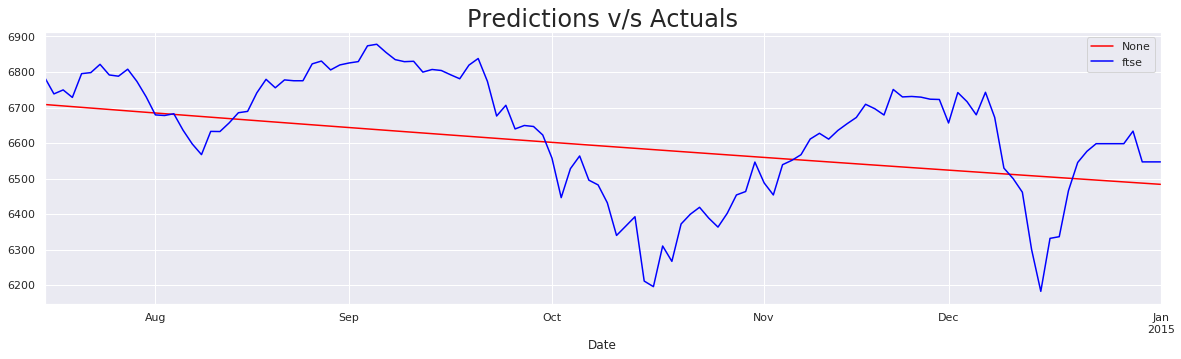

In [20]:
df_pred.predictions[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions v/s Actuals", size = 24)
plt.legend()
plt.show()

#### Hence, AR Models don't perform well when predicting non-stationary data

## Forecasting Returns with AR and MA

## AR

In [22]:
model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

### Making the Predictions

In [24]:
df_pred_ret_ar = results_ret_ar.predict(start = start_date, end = end_date)

### Plotting the Predictions

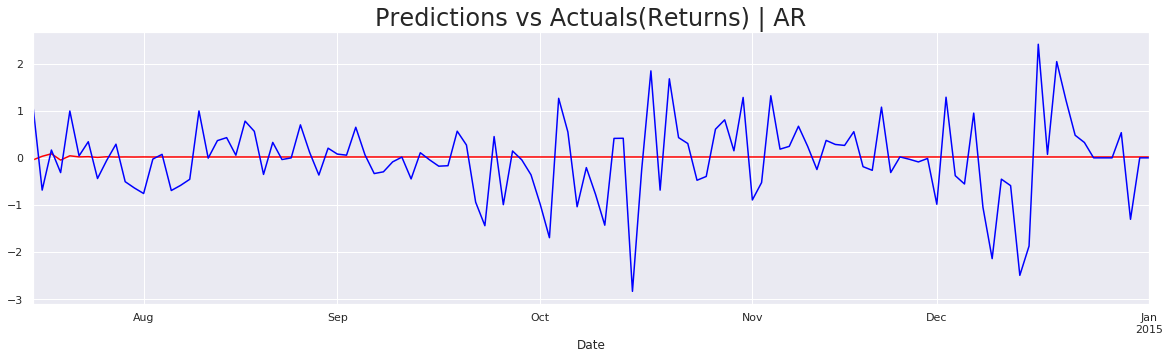

In [29]:
df_pred_ret_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | AR", size = 24)
plt.show()

## MA

In [27]:
model_ret_ma = ARIMA(df.ret_ftse[1:], order = (0,0,5))
results_ret_ma = model_ret_ma.fit()

### Making the Predictions

In [28]:
df_pred_ret_ma = results_ret_ma.predict(start = start_date, end = end_date)

### Plotting the Predictions

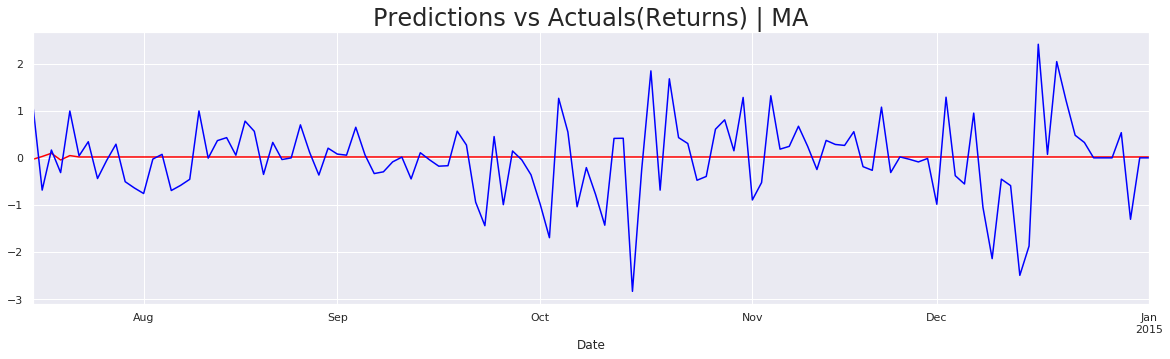

In [31]:
df_pred_ret_ma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | MA", size = 24)
plt.show()

## ARMA

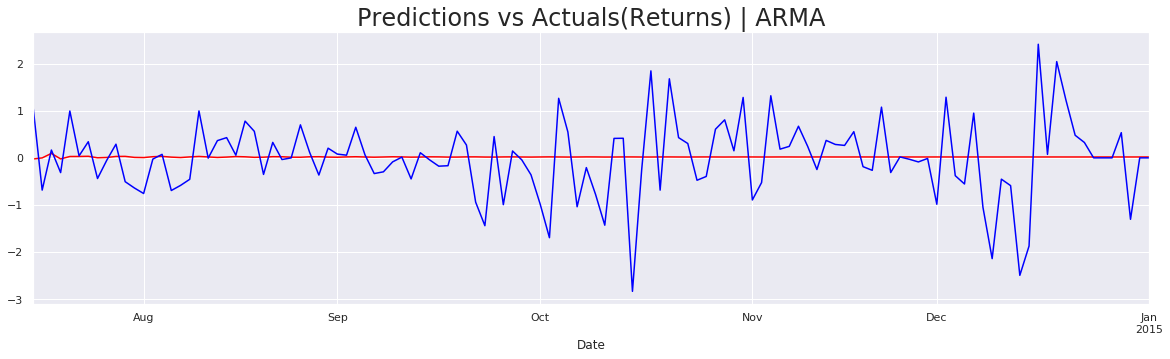

In [36]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order = (4,0,5))
results_ret_arma = model_ret_arma.fit()

df_pred_ret_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_ret_arma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | ARMA", size = 24)
plt.show()

## ARMAX Model

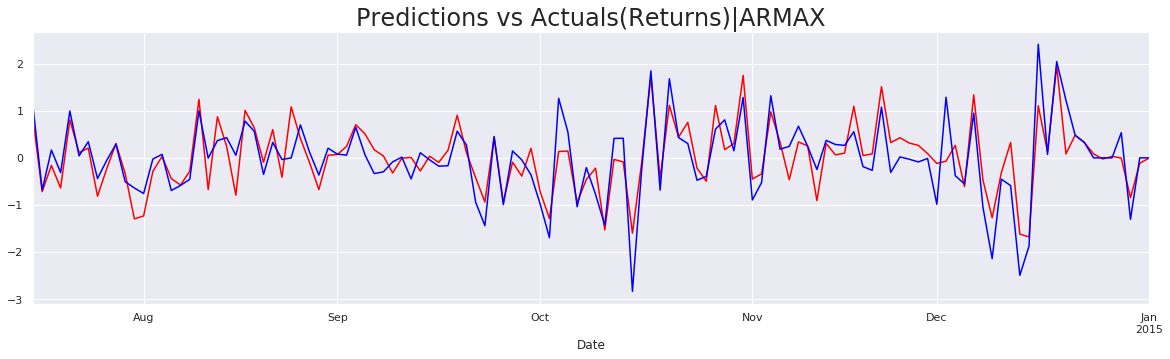

In [63]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_ret_armax = results_ret_armax.predict(start = start_date, end = end_date,
                                             exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_ret_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns)|ARMAX", size = 24)
plt.show()

## ARIMA Model

In [46]:
df_test['int_ftse_ret'] = df_test.ftse.diff(1) 

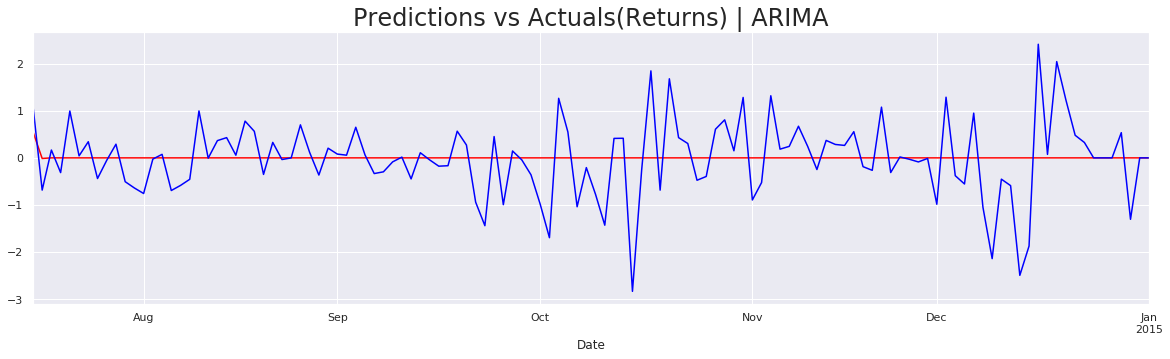

In [51]:
model_arima = ARIMA(df.ret_ftse[1:], order = (1,1,1))
results_arima = model_arima.fit()

df_pred_arima = results_arima.predict(start = start_date, end = end_date)

df_pred_arima[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | ARIMA", size = 24)
plt.show()

## ARIMAX Model

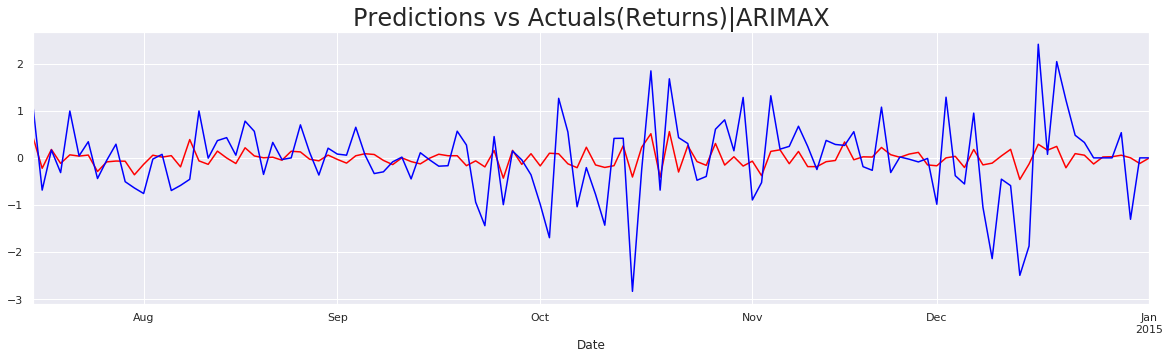

In [55]:
model_arimax = ARIMA(df.ret_ftse[1:], exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order = (1,1,1))
results_arimax = model_arimax.fit()

df_pred_arimax = results_arimax.predict(start = start_date, end = end_date,
                                             exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_arimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns)|ARIMAX", size = 24)
plt.show()

## SARMA Model

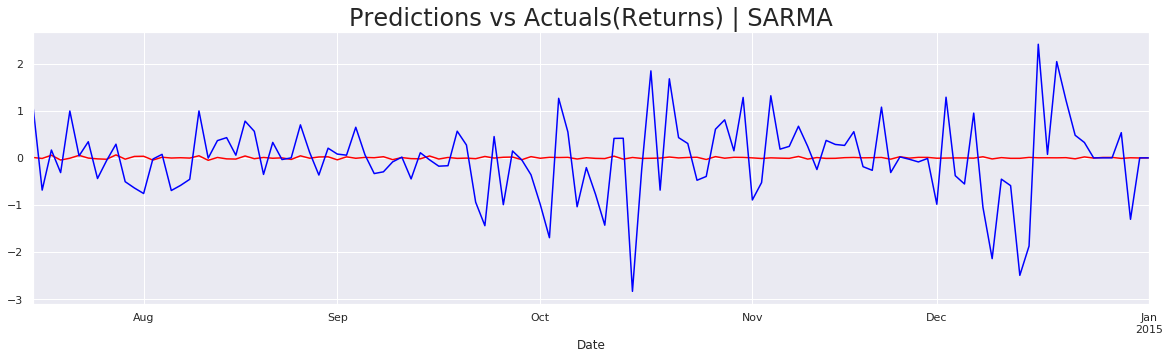

In [58]:
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_ret_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_ret_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | SARMA", size = 24)
plt.show()

## SARIMAX

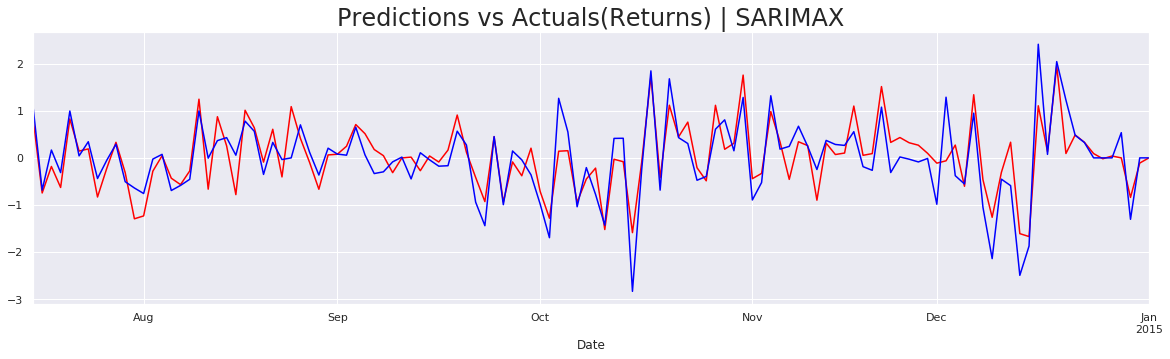

In [61]:
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order = (3,0,4),
                           seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_ret_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, exog =  df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_ret_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | SARIMAX", size = 24)
plt.show()

## AUTO ARIMA

In [65]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [68]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                           exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]), index = df_test[start_date:end_date].index)

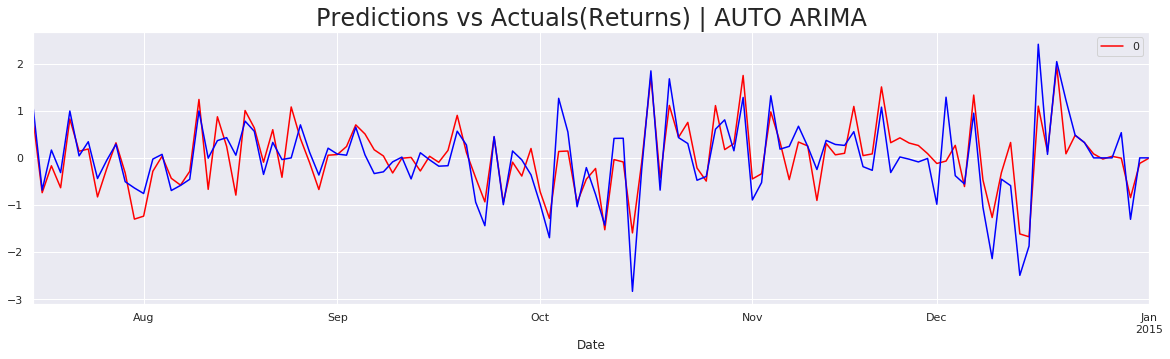

In [69]:
df_auto_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actuals(Returns) | AUTO ARIMA", size = 24)
plt.show()

## Forecsting Volatility

In [70]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "Constant", dist = "Normal" )

In [71]:
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7311.064967249472
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7311.064229906422
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [75]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

## Plotting the Predictions

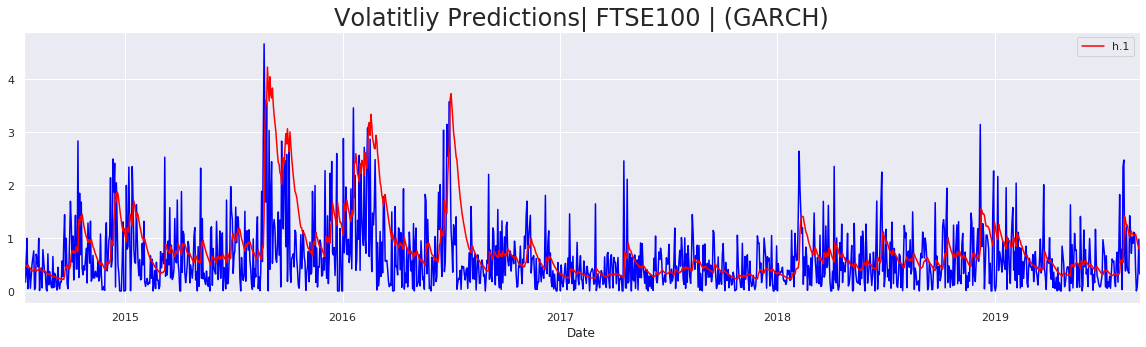

In [76]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatitliy Predictions| FTSE100 | (GARCH)", size = 24 )
plt.show()


## Multivariate Regession(Multivariate Forecasting)

In [77]:
from statsmodels.tsa.api import VAR

In [78]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [79]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [80]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, May, 2020
Time:                     18:02:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039150         0.016160            2.423           0.015
L1.ret_spx           -0.110568         0.017558           -6.297           0.000
L1.ret_dax            0.065289         0.019034           

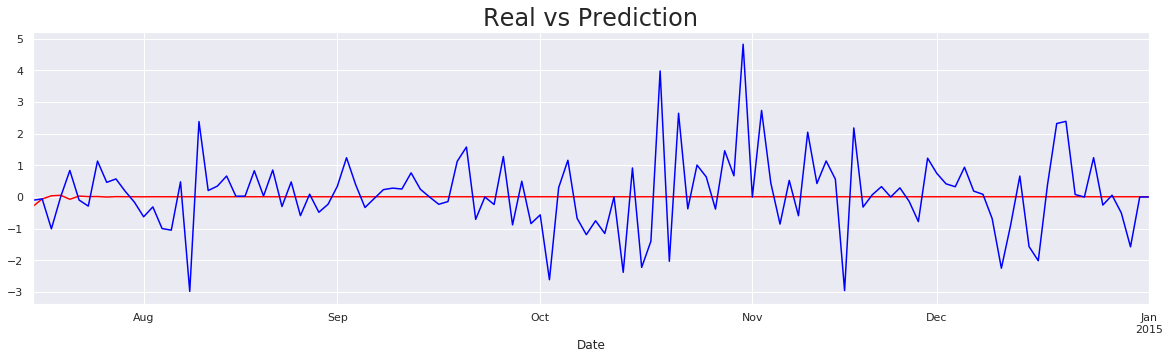

In [81]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

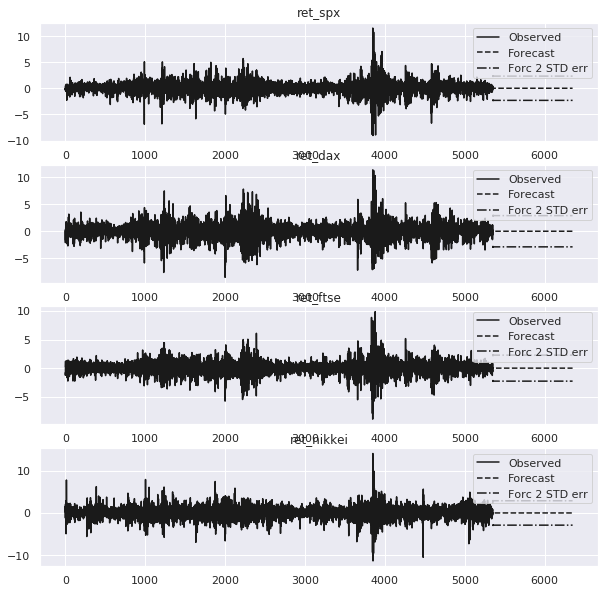

In [82]:
results_var_ret.plot_forecast(1000)
plt.show()